<a href="https://colab.research.google.com/github/scottspurlock/random_research_ideas/blob/main/distributions_and_distances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding the middle between two Gaussian distributions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.spatial import distance
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
# Adapted from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(mu, sigma, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of sigma around mu.

    Parameters
    ----------
    mu = center of elipse.
    sigma = covariance matrix.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    # cov = np.cov(x, y)
    cov = sigma
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    # mean_x = np.mean(x)
    mean_x = mu[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    # mean_y = np.mean(y)
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


## Take 1: Mahalanobis distance
This doesn't seem to work right. See a better version further down.

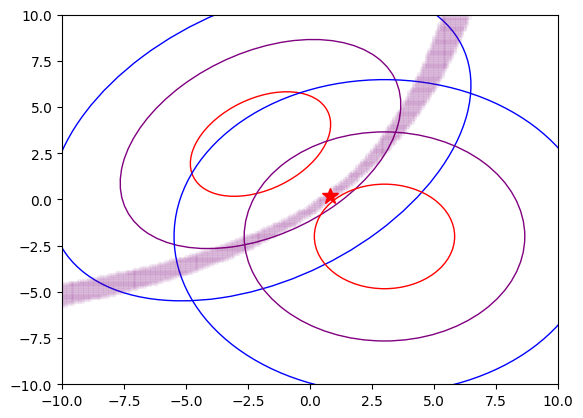

In [3]:
# all the points
x, y = np.mgrid[-10:10:.1, -10:10:.1]
data = np.dstack((x, y)) # nx x ny x 2

# distribution 1
mu1 = np.array([-2, 3])
sigma1 = np.array([[8, 3],
                   [3, 8]])
distribution1 = multivariate_normal(mu1, sigma1)
z1 = distribution1.pdf(data)

# distribution 2
mu2 = np.array([3, -2])
sigma2 = np.array([[8, 0.],
                   [0, 8]])
distribution2 = multivariate_normal(mu2, sigma2)
z2 = distribution2.pdf(data)


# plt.contourf(x, y, z1)
# plt.contour(x, y, z1)
# plt.contour(x, y, z2)
plt.figure()
confidence_ellipse(mu1, sigma1, plt.gca(), n_std=1, label=r'$1\sigma$', edgecolor='red')
confidence_ellipse(mu1, sigma1, plt.gca(), n_std=2, label=r'$2\sigma$', edgecolor='purple')
confidence_ellipse(mu1, sigma1, plt.gca(), n_std=3, label=r'$3\sigma$', edgecolor='blue')

confidence_ellipse(mu2, sigma2, plt.gca(), n_std=1, label=r'$1\sigma$', edgecolor='red')
confidence_ellipse(mu2, sigma2, plt.gca(), n_std=2, label=r'$2\sigma$', edgecolor='purple')
confidence_ellipse(mu2, sigma2, plt.gca(), n_std=3, label=r'$3\sigma$', edgecolor='blue')

# show points on the boundary between distributions
positions = np.vstack([x.ravel(), y.ravel()]).T # gives n x 2
for d in positions:
    # find the mahalanobis distance from the point to each mean
    dist1 = distance.mahalanobis(d, mu1, sigma1)
    dist2 = distance.mahalanobis(d, mu2, sigma2)

    # if this point in space is about equidistant from each mean
    if np.abs(dist1 - dist2) < 1 and dist2 < 40:
        plt.plot(d[0], d[1], '.', color='purple', alpha=0.05)

# find the center point iteratively
vec = mu1 - mu2
ratio = 0.5
mid = mu2 + ratio * vec
dist1 = distance.mahalanobis(mid, mu1, sigma1)
dist2 = distance.mahalanobis(mid, mu2, sigma2)
times = 0
while np.abs(dist1 - dist2) > 1e-5 and times < 100:
    times += 1
    if dist1 > dist2:
        ratio += 0.5 - dist2/(dist1+dist2)
    else:
        ratio -= 0.5 - dist1/(dist1+dist2)

    mid = mu2 + ratio * vec

    dist1 = distance.mahalanobis(mid, mu1, sigma1)
    dist2 = distance.mahalanobis(mid, mu2, sigma2)
plt.plot(mid[0], mid[1], '*', color='red', markersize=12)

plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.show()


## Instead of mahalanobis distance, we could find where pdf's are equal


00: [0.5 0.5], pdf1: 0.006149, pdf2: 0.009108
01: [0.01500662 0.98499338], pdf1: 0.009527, pdf2: 0.006532
02: [0.4347192 0.5652808], pdf1: 0.006558, pdf2: 0.008740
03: [0.14589838 0.85410162], pdf1: 0.008544, pdf2: 0.007186
04: [0.30318517 0.69681483], pdf1: 0.007428, pdf2: 0.008015
05: [0.24083966 0.75916034], pdf1: 0.007861, pdf2: 0.007682
06: [0.25790642 0.74209358], pdf1: 0.007741, pdf2: 0.007772
07: [0.25527002 0.74472998], pdf1: 0.007760, pdf2: 0.007758


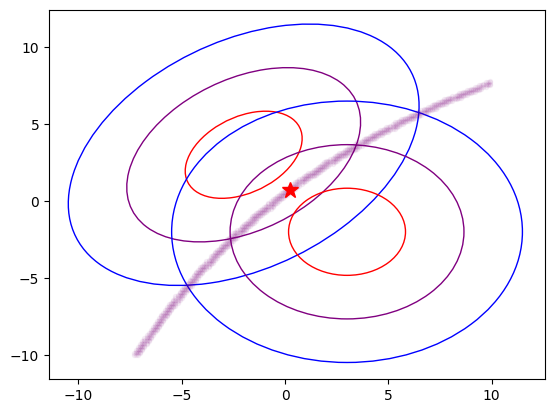

In [4]:
plt.figure()
confidence_ellipse(mu1, sigma1, plt.gca(), n_std=1, label=r'$1\sigma$', edgecolor='red')
confidence_ellipse(mu1, sigma1, plt.gca(), n_std=2, label=r'$2\sigma$', edgecolor='purple')
confidence_ellipse(mu1, sigma1, plt.gca(), n_std=3, label=r'$3\sigma$', edgecolor='blue')

confidence_ellipse(mu2, sigma2, plt.gca(), n_std=1, label=r'$1\sigma$', edgecolor='red')
confidence_ellipse(mu2, sigma2, plt.gca(), n_std=2, label=r'$2\sigma$', edgecolor='purple')
confidence_ellipse(mu2, sigma2, plt.gca(), n_std=3, label=r'$3\sigma$', edgecolor='blue')

# show points on the boundary between distributions
positions = np.vstack([x.ravel(), y.ravel()]).T # gives n x 2
for d in positions:
    # find the pdf for the point under each distribution
    pdf1 = distribution1.pdf(d)
    pdf2 = distribution2.pdf(d)

    # if this point in space has equal pdf
    # if np.abs(pdf1 - pdf2) < 1e-3 and pdf1 > 1e-4 and pdf2 > 1e-4:
    # Better: if the difference divided by the sum is small
    # (handles points far from both distributions)
    if np.abs(pdf1 - pdf2) / (pdf1 + pdf2) < 0.1:
        plt.plot(d[0], d[1], '.', color='purple', alpha=0.05)

# find the center point iteratively
vec = mu1 - mu2
ratio = 0.5
mid = mu2 + ratio * vec
pdf1 = distribution1.pdf(mid)
pdf2 = distribution2.pdf(mid)

times = 0
alpha = 1
while np.abs(pdf1 - pdf2) > 1e-7 and times < 100:
    print(f'{times:02d}: {mid}, pdf1: {pdf1:.6f}, pdf2: {pdf2:.6f}')
    times += 1
    ratio += alpha * (0.5 - pdf1/(pdf1 + pdf2))
    alpha *= 0.9
    mid = mu2 + ratio * vec

    pdf1 = distribution1.pdf(mid)
    pdf2 = distribution2.pdf(mid)

plt.plot(mid[0], mid[1], '*', color='red', markersize=12)
plt.show()